In [1]:
code_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/code"
import os, sys
if code_dir not in sys.path:
    sys.path.append(code_dir)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
import seaborn as sns

# TODO:
* DONE first apply k-means to 3D scene coordinates from a single image
* DONE apply kmeans to every 100th pixel - compare with kmeans applied to all pixels
* DONE - use kmeans.predict() -then try figuring out the way where you can formulate k-means clustering based onjust a sample of pixels
* extend the problem to all coordinates
* need to figure out how to obtain whitening matrix

# Load scene coordinate data

In [3]:
data_dir = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512/"

In [4]:
data_size = 1
images = np.zeros((data_size, 256, 512, 3), dtype=np.float32)
scene_coords = np.zeros((data_size, 256, 512, 3), dtype=np.float32)
pixel_bearings = np.zeros((data_size, 256, 512, 3), dtype=np.float32)

for data in tqdm(range(1,data_size + 1)):
    coord_npz = f"{data:04}_rendered.png_config.npz"
    npz_data = np.load(data_dir + coord_npz)
    
    images[int(data)-1,:,:,:] = npz_data['image_colors'] / 255.
    scene_coords[int(data)-1,:,:,:] = npz_data['points_3d_world'] 
    pixel_bearings[int(data)-1,:,:,:] = npz_data['points_3d_sphere']

100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


# playing with whitening matrix

In [5]:
img = scene_coords[0]

In [7]:
print(img.max())
print(img.min())

24.125
-5.9804688


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


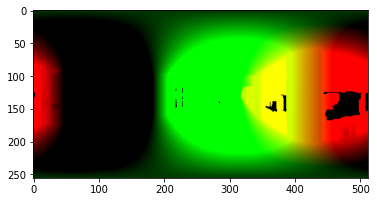

In [17]:
tmp = (img - img.min()) / (img.max() - img.min())
plt.imshow(img)

In [40]:
def whiten(X, fudge=1E-9):

    # the matrix X has dimensions: num_points_in_label BY 3 coords
    # apply zero centering
    mean = np.mean(X, axis=0) # dim=3
    X = X - mean
    
    # get the covariance matrix
    Xcov = np.dot(X.T,X)

    # eigenvalue decomposition of the covariance matrix
    d, V = np.linalg.eigh(Xcov)

    # a fudge factor can be used so that eigenvectors associated with
    # small eigenvalues do not get overamplified.
    D = np.diag(1. / np.sqrt(d+fudge))

    # whitening matrix
    W = np.dot(np.dot(V, D), V.T)

    # multiply by the whitening matrix
    X_white = np.dot(X, W)

    return X_white, W

In [34]:
image_flat = np.reshape(img, (-1,3))
mean = np.mean(image_flat, axis=0)
print(mean)

[-0.541607    0.45321316 -3.8284001 ]


In [35]:
img_whitenned, W = whiten(image_flat)

(array([2.9819e+04, 8.9517e+04, 8.6290e+03, 1.8210e+03, 5.0200e+02,
        6.3800e+02, 4.2000e+01, 2.0000e+01, 6.0000e+01, 2.4000e+01]),
 array([0.06233243, 0.15609919, 0.24986593, 0.3436327 , 0.43739945,
        0.5311662 , 0.62493294, 0.71869975, 0.8124665 , 0.90623325,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

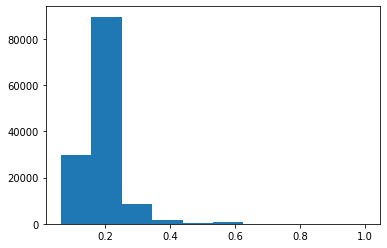

In [36]:
tmp = (img_whitenned - img_whitenned.min()) / (img_whitenned.max() - img_whitenned.min())
plt.hist(tmp[:,1])

In [37]:
W_inv = np.linalg.inv(W)

In [38]:
img_back = np.dot(img_whitenned, W_inv) + mean

In [39]:
W_inv

array([[474.88425  , -38.293163 ,  12.008048 ],
       [-38.29317  , 666.4346   ,  -6.4235783],
       [ 12.008046 ,  -6.423571 , 534.93274  ]], dtype=float32)

In [15]:
img_back = np.reshape(img_back, (256,512,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


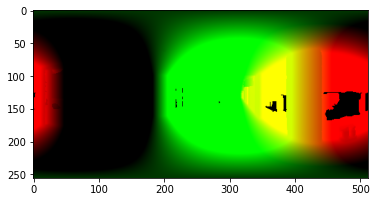

In [16]:
plt.imshow(img_back[:,:,:])

# Toy example - single coords file

In [41]:
coords = scene_coords[0].copy()

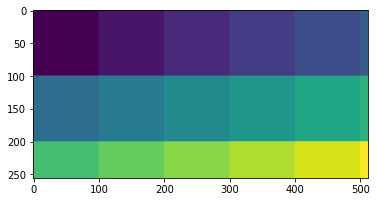

In [47]:
regions = np.zeros((coords.shape[0], coords.shape[1]))
ind = 0
step = 100
for r in np.arange(0,coords.shape[0], step):
    for c in np.arange(0,coords.shape[1], step):
        regions[ r:r+step, c:c+step] = ind
        ind +=1

plt.imshow(regions)

In [59]:
coords_flat = np.reshape(coords, (-1, 3))
regions_flat = np.reshape(regions, (-1))

**normalised distribution of all coordinates:**

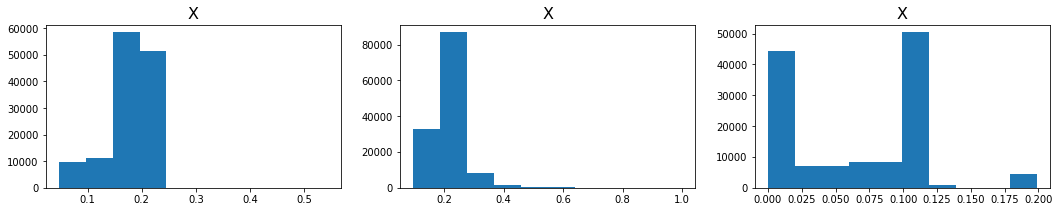

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,3))
normalised = (coords_flat - coords_flat.min()) / (coords_flat.max() - coords_flat.min()) 
ax1.hist(normalised[:,0]); ax1.set_title("X", fontsize=16)
ax2.hist(normalised[:,1]); ax2.set_title("Y", fontsize=16)
ax3.hist(normalised[:,2]); ax3.set_title("Z", fontsize=16)
plt.show()

**norm Distribution of coords only in the first region:** 

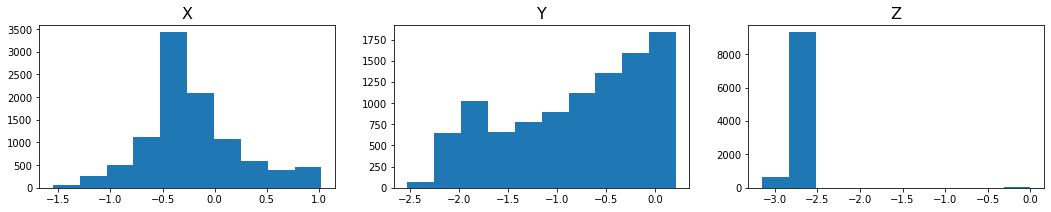

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,3))
coords_first_region = np.where(regions_flat == 0)
coords_flat_1st_reg = coords_flat[coords_first_region]
normalised = (coords_flat_1st_reg - coords_flat_1st_reg.min()) / (coords_flat_1st_reg.max() - coords_flat_1st_reg.min()) 
ax1.hist(coords_flat_1st_reg[:,0]); ax1.set_title("X", fontsize=16)
ax2.hist(coords_flat_1st_reg[:,1]); ax2.set_title("Y", fontsize=16)
ax3.hist(coords_flat_1st_reg[:,2]); ax3.set_title("Z", fontsize=16)
plt.show()

**Comment:** distribution has improved (covers wider range) because **min** and **max** now come from within the label. 

# Applying k-means to a single image

In [26]:
coords_flat = np.reshape(scene_coords[0], (-1,3))
coords_flat.shape

(131072, 3)

In [50]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords_flat.astype(np.float))

In [51]:
kmeans.labels_.shape

(131072,)

In [52]:
coords_clustered = np.reshape(kmeans.labels_, (256,512))

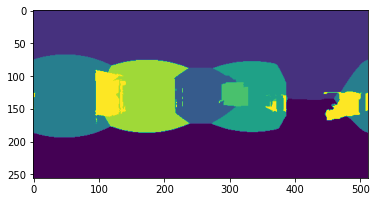

In [53]:
plt.imshow(coords_clustered)

In [54]:
kmeans.cluster_centers_

array([[-0.25490675,  0.28890751, -5.36803124],
       [-0.2174672 ,  0.28652693, -2.66942321],
       [-3.29805401,  3.72021419, -3.97951517],
       [ 0.04189897, -1.74148624, -4.0019661 ],
       [ 0.41354465,  3.00407679, -4.07512128],
       [-1.06695187, 11.1318715 , -3.97162087],
       [-3.33576137, -0.23988124, -4.05493379],
       [ 0.        ,  0.        ,  0.        ]])

In [55]:
kmeans.predict(np.array([[0.,0.,0.], [-2.,3.,-5.]]))

array([7, 2], dtype=int32)

# Applying k-means to a single image - using subset of points

In [63]:
shuffled_coords = np.random.permutation(coords_flat)

In [76]:
kmeans_subset = KMeans(n_clusters=8, random_state=0).fit(shuffled_coords[::100].astype(np.float))

In [77]:
kmeans_subset_all_points = kmeans_subset.predict(coords_flat.astype(np.float))

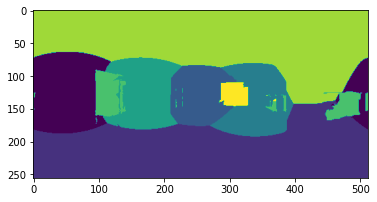

In [78]:
kmeans_subset_all_points = np.reshape(kmeans_subset_all_points, (256,512))
plt.imshow(kmeans_subset_all_points)

**Observation:** using subset of points (every 100th) didn't deteriorate performence very much, but it is important to shuffle dataset first, to have better coverage of the space.

# Apply kmeans clustering to all points

In [82]:
# get all the points together
all_coords_flat = np.reshape(scene_coords, (-1,3))
all_coords_flat.shape

(48496640, 3)

In [83]:
# do kmeans based on every 100th point
shuffled_all_coords = np.random.permutation(all_coords_flat)
kmeans_all_points = KMeans(n_clusters=20, random_state=0).fit(shuffled_all_coords[::100].astype(np.float))

In [84]:
coords_flat = np.reshape(scene_coords[0], (-1,3))

In [85]:
# predict labels for every image in a for loop and save to a new directory
pred_coords_clustering = kmeans_all_points.predict(coords_flat.astype(np.float))

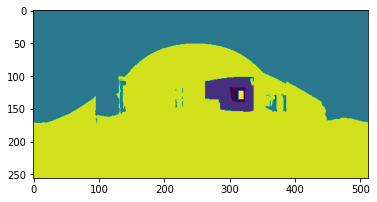

In [86]:
pred_coords_clustering = np.reshape(pred_coords_clustering, (256,512))
plt.imshow(pred_coords_clustering)

# question:
### how do you make your kmeans density independent?
curently k-means will form more clusters in regions which are densly sampled with 3D points.
* make the points selected for kmeans unifromly spaced. (enforce this during downsampling)
* NOT FOUND - look for some kmeans specific parameter that could help

### alternativelly the plot shows that kmeans doesn't do such a bad job
but definitely i need to think more about it

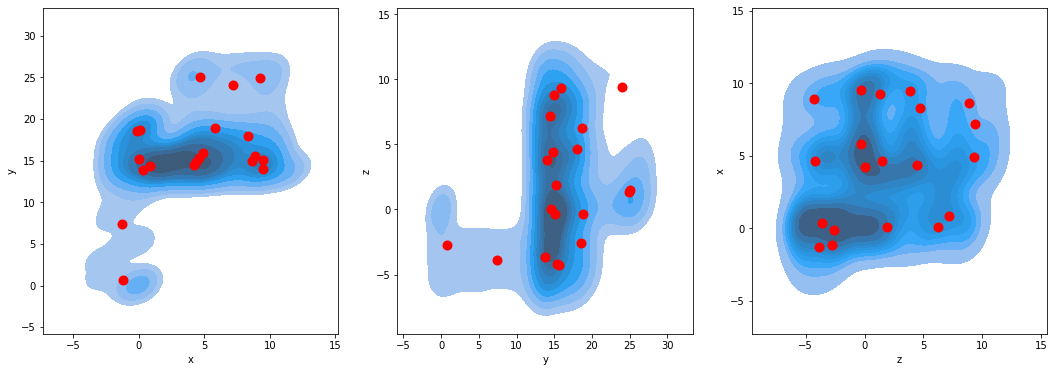

In [133]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
sns.kdeplot(x=shuffled_all_coords[::10000][:,0], y=shuffled_all_coords[::10000][:,1], ax=ax1, fill=True)
ax1.scatter(kmeans_all_points.cluster_centers_[:,0], kmeans_all_points.cluster_centers_[:,1], color='r', linewidths=4)
ax1.set_xlabel("x")
ax1.set_ylabel("y")

sns.kdeplot(x=shuffled_all_coords[::10000][:,1], y=shuffled_all_coords[::10000][:,2], ax=ax2, fill=True)
ax2.scatter(kmeans_all_points.cluster_centers_[:,1], kmeans_all_points.cluster_centers_[:,2], color='r', linewidths=4)
ax2.set_xlabel("y")
ax2.set_ylabel("z")

sns.kdeplot(x=shuffled_all_coords[::10000][:,2], y=shuffled_all_coords[::10000][:,0], ax=ax3, fill=True)

ax3.scatter(kmeans_all_points.cluster_centers_[:,2], kmeans_all_points.cluster_centers_[:,0], color='r', linewidths=4)
ax3.set_xlabel("z")
ax3.set_ylabel("x")
plt.show()

# Whiten scene_coords

In [207]:
all_coords_cluster_class = kmeans_all_points.predict(all_coords_flat.astype(float))

In [220]:
Ws_inv = np.zeros((20,3,3))
Ms = np.zeros((20,3))

In [221]:
all_coords_scene_back_flat = np.zeros((all_coords_flat.shape[0], 3))
all_coords_local_flat = np.zeros((all_coords_flat.shape[0], 3))

for i in tqdm(range(20)):
    indexes_class = np.where(all_coords_cluster_class == i, True, False)
    class_coords_flat = all_coords_flat[indexes_class]
    
    shuffled_coords = np.random.permutation(class_coords_flat)
    
    _, W = whiten(shuffled_coords[::100])
    
    mean = np.mean(class_coords_flat, axis=0)
    all_coords_local_flat[indexes_class] = np.dot(class_coords_flat - mean, W)
    
    W_inv = np.linalg.inv(W)
    
    # check
    all_coords_scene_back_flat[indexes_class] = np.dot(all_coords_local_flat[indexes_class], W_inv) + mean
    
    tmp = np.reshape(all_coords_scene_back_flat, (370,256,512,3))
    
    Ws_inv[i] = W_inv
    Ms[i] = mean
    
all_coords_local = np.reshape(all_coords_local_flat, (370,256,512,3))
all_coords_scene_back = np.reshape(all_coords_scene_back_flat, (370,256,512,3))

100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


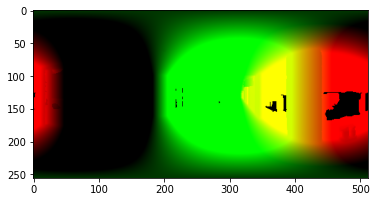

In [222]:
plt.imshow(all_coords_scene_back[0])

# Check - whether whitening works as you expect

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


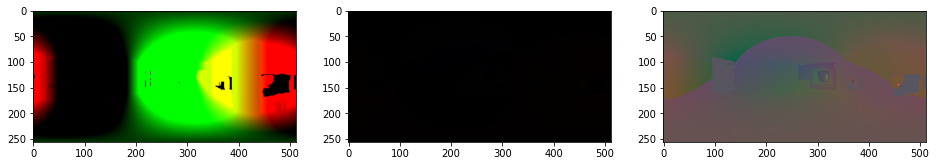

In [201]:
ind=0

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16,6))
ax1.imshow(scene_coords[ind])
ax2.imshow(all_coords_local[ind])
tmp = (all_coords_local[ind] - all_coords_local[ind].min()) / (all_coords_local[ind].max() - all_coords_local[ind].min())
ax3.imshow(tmp)
plt.show()

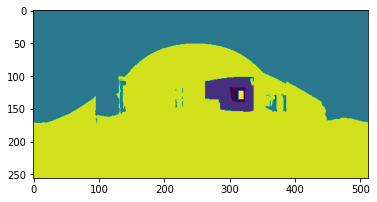

In [197]:
# predict right clusters
tmp_scene_coords = np.reshape(scene_coords[0], (-1,3))
tmp_coords_flat_class = kmeans_all_points.predict(tmp_scene_coords.astype(float))
plt.imshow(np.reshape(tmp_coords_flat_class, (256,512)))

100%|██████████| 20/20 [00:00<00:00, 594.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


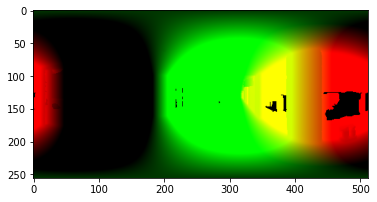

In [203]:
tmp_scene_coords_flat = np.zeros((256*512,3))
tmp_coords_flat = np.reshape(all_coords_local[0], (-1,3))

for i in tqdm(range(20)):
    indexes_class = np.where(tmp_coords_flat_class == i, True, False)
    
    mean = Ms[i]
    W_inv = Ws_inv[i]
    
    tmp_scene_coords_flat[indexes_class] = np.dot(tmp_coords_flat[indexes_class], W_inv) + mean
    
tmp_scene_coords_ = np.reshape(tmp_scene_coords_flat, (256,512,3))
plt.imshow(tmp_scene_coords_)

# What do I want in my new .npz data file?:
* HAVE image_colors
* HAVE bearings
* HAVE scene_coordinates
* HAVE mask
* coord_region_labels
* local_scene_coordinates
* coord_region_centers

In [204]:
# get mask
scene_coords_summed = np.sum(scene_coords, axis=-1)
masks = np.where(scene_coords_summed == 0, 0, 1).astype(bool)

In [205]:
# get 3D point region class
points_region_class = np.reshape(all_coords_cluster_class, (370,256,512))

In [244]:
dir_to_save = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512_complete/"
data_dir = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512/"

if not os.path.exists(dir_to_save):
    os.makedirs(dir_to_save)
    

for ind in tqdm(range(370)):
    npz_file_name = f"{ind+1:04}_rendered.png_config.npz" 
    npz_data = np.load(data_dir + npz_file_name)
      
    np.savez(dir_to_save + npz_file_name, 
             image_colors= npz_data['image_colors'] / 255., 
             points_3d_world= npz_data['points_3d_world'], 
             points_3d_sphere= npz_data['points_3d_sphere'], 
             R_blender=npz_data['R_blender'], 
             T_blender=npz_data['T_blender'], 
             mask=masks[ind], 
             points_region_class= points_region_class[ind], 
             local_scene_coords= all_coords_local[ind], 
             W_inv= Ws_inv, 
             M= Ms)

100%|██████████| 370/370 [08:53<00:00,  1.44s/it]


# Load data - check

In [233]:
ind = 0
npz_file_name = f"{ind+1:04}_rendered.png_config.npz"
npz_data = np.load(dir_to_save + coord_npz)
npz_data.files

['image_colors',
 'points_3d_world',
 'points_3d_sphere',
 'R_blender',
 'T_blender',
 'mask',
 'points_region_class',
 'local_scene_coords',
 'W_inv',
 'M']

### check: img colors 

In [234]:
npz_data['image_colors'].max()

0.9098039215686274

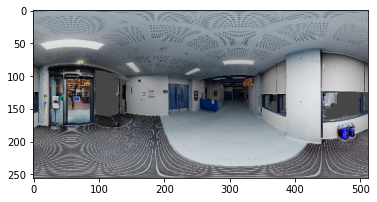

In [236]:
plt.imshow(npz_data['image_colors'])
plt.show()

### check: scene coords

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


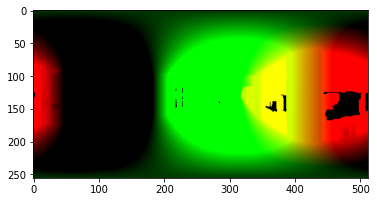

In [237]:
plt.imshow(npz_data['points_3d_world'])
plt.show()

### check: mask

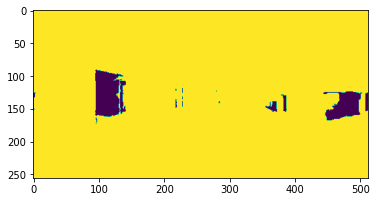

In [238]:
plt.imshow(npz_data['mask'])
plt.show()

### check: points_region_class

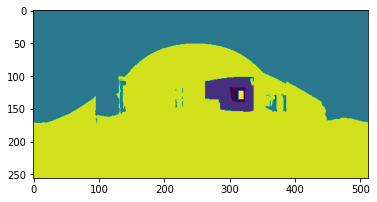

In [239]:
plt.imshow(npz_data['points_region_class'])
plt.show()

### check: local_scene_coords

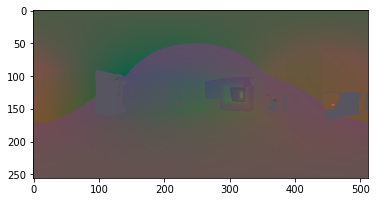

In [227]:
tmp = (npz_data['local_scene_coords'] - npz_data['local_scene_coords'].min()) / (npz_data['local_scene_coords'].max() - npz_data['local_scene_coords'].min())
plt.imshow(tmp)

### check: W_inv and M

In [240]:
npz_data['W_inv'][0]

array([[ 758.81488037,   -6.25672436,  665.9642334 ],
       [  -6.25672483,  272.54922485,   -6.65937185],
       [ 665.9642334 ,   -6.65937138, 1026.16015625]])

In [241]:
npz_data['M'][0]

array([ 8.83374023, 14.98736954,  8.43650913])

In [242]:
npz_data['W_inv'].shape

(20, 3, 3)

In [243]:
npz_data['M'].shape

(20, 3)